In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
import math

def format_value_with_uncertainty(value, variance, sample_size):
    def round_to_one_significant(x):
        if x == 0:
            return 0.0
        exponent = math.floor(math.log10(abs(x)))
        mantissa = x / (10 ** exponent)
        rounded_mantissa = round(mantissa)
        if rounded_mantissa == 10:
            rounded_mantissa = 1
            exponent += 1
        return rounded_mantissa * (10 ** exponent)
    
    def get_decimal_places(x):
        s = "{0:.10f}".format(x).rstrip('0').rstrip('.')
        return len(s.split('.')[1]) if '.' in s else 0
    
    std_dev = math.sqrt(variance)
    standard_error = std_dev / math.sqrt(sample_size)
    
    if standard_error == 0:
        return f"{round(value):.0f} ± 0"
    
    rounded_uncertainty = round_to_one_significant(standard_error)
    decimal_places = get_decimal_places(rounded_uncertainty)
    
    formatted_value = round(value, decimal_places)
    formatted_uncertainty = round(rounded_uncertainty, decimal_places)
    
    return f"{formatted_value:.{decimal_places}f} ± {formatted_uncertainty:.{decimal_places}f}"

In [14]:
def print_hist_dencity(dist, plot_range, save_path):
    a = dict()
    a[10] = dist.rvs(10)
    a[50] = dist.rvs(50)
    a[1000] = dist.rvs(1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    for num, ax in zip(a.keys(), axes):
        ax.set_title(f'Number of samples {num}')
        if isinstance(dist.dist, stats.rv_continuous):
            ax.hist(a[num], bins=np.sqrt(num).astype(int), range=plot_range, density=True, color='blue', alpha=0.5)
            x = np.linspace(plot_range[0], plot_range[1], num=int(1e5))
            ax.plot(x, dist.pdf(x), color='red')
        else:
            x = np.arange(plot_range[0], plot_range[1])
            ax.hist(a[num], bins=x, range=plot_range, density=True, color='blue', alpha=0.5)
            ax.plot(x, dist.pmf(x))
    if save_path:
        plt.savefig(save_path)
    plt.show()

def q_mid(x):
    return np.percentile(x, [75, 25]).mean()

def statistics(dist):
    stats = np.empty((3, 6, 1000))
    for i in range(1000):
        a = dict().fromkeys(range(3))
        a[0] = dist.rvs(10)
        a[1] = dist.rvs(100)
        a[2] = dist.rvs(1000)
        for j in range(3):
            stats[j, :3, i] = np.array([a[j].mean(), np.median(a[j]), q_mid(a[j])])
            stats[j, 3:, i] = stats[j, :3, i] ** 2
    ans = stats.mean(axis=2)
    ans[:, 3:] = ans[:, 3:]-ans[:,:3]**2
    ans = pd.DataFrame(ans, columns=['Mean','Median','$z_Q$', 'Mean variance','Median variance','$z_Q$ variance'])
    ans = pd.concat((pd.DataFrame(np.array([10, 100, 1000]), columns=['Sample size']), ans), axis=1)
    for i in range(3):
        ans['Mean'][i] = format_value_with_uncertainty(ans['Mean'][i], ans['Mean variance'][i], ans['Sample size'][i])
        ans['Median'][i] = format_value_with_uncertainty(ans['Median'][i], ans['Median variance'][i], ans['Sample size'][i])
        ans['$z_Q$'][i] = format_value_with_uncertainty(ans['$z_Q$'][i], ans['$z_Q$ variance'][i], ans['Sample size'][i])
    return ans[['Sample size', 'Mean', 'Median', '$z_Q$']]

In [8]:
def print_boxplot(dist, save_path=None):
    a = dict()
    a[10] = dist.rvs(20)
    a[50] = dist.rvs(100)
    a[1000] = dist.rvs(1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    outliers = dict.fromkeys(a.keys())
    for num, ax in zip(a.keys(), axes):
        ax.set_title(f'Number of samples {num}')
        bplot = ax.boxplot(a[num])
        outliers[num] = len(bplot["fliers"][0].get_ydata())
    if save_path:
        plt.savefig(save_path)
    plt.show()
    return outliers

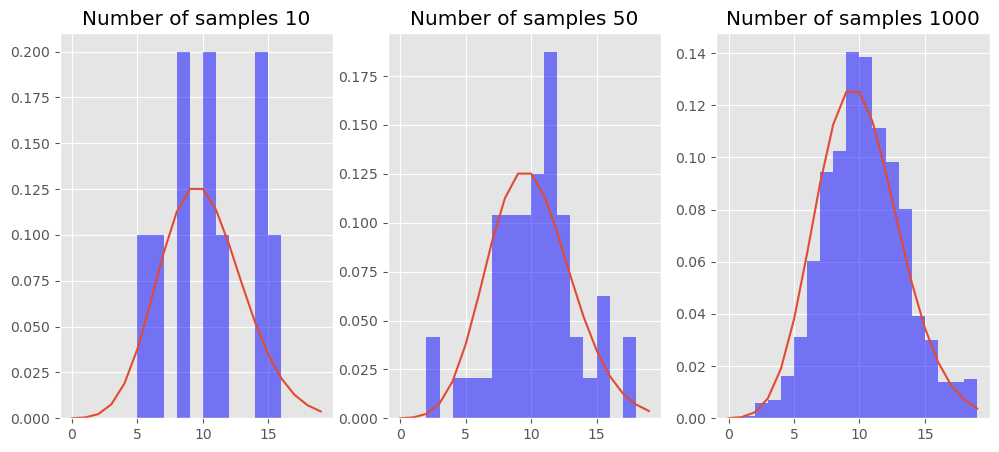

In [7]:
print_hist_dencity(stats.poisson(10), (0, 20), './images/poisson')

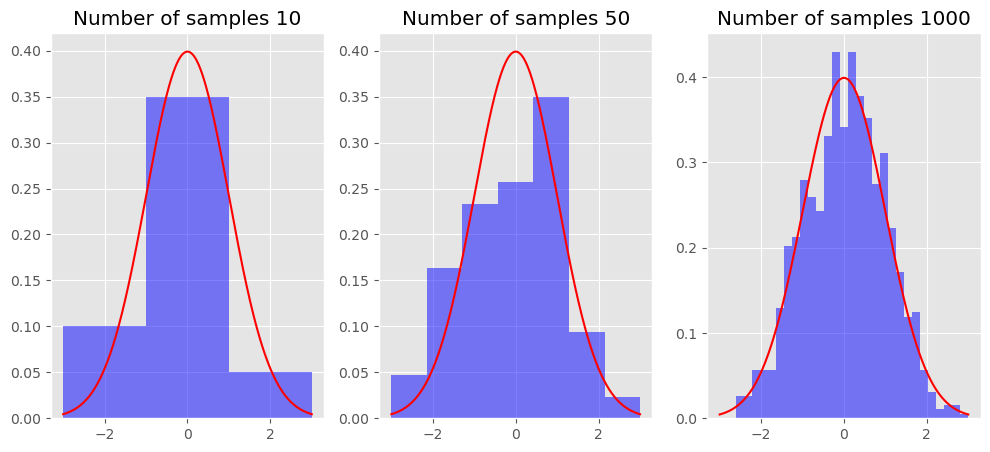

In [6]:
print_hist_dencity(stats.norm(0, 1), (-3, 3), './norm')

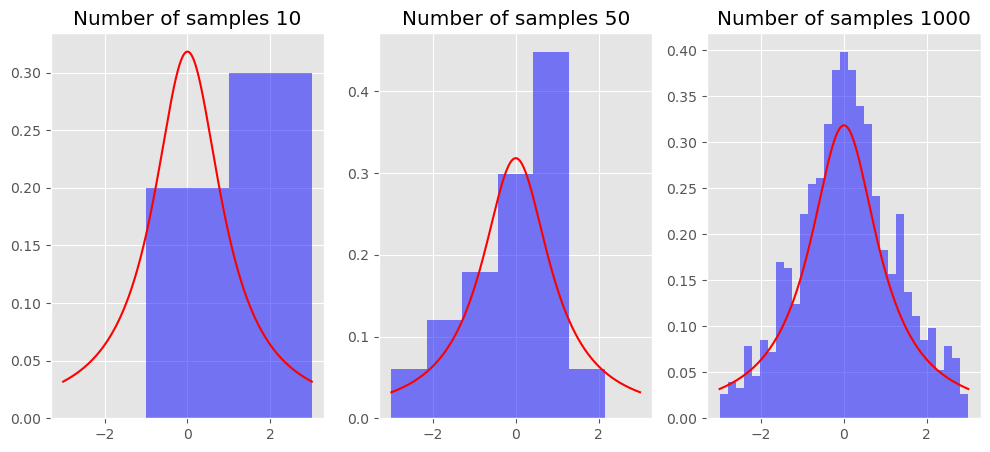

In [7]:
print_hist_dencity(stats.cauchy(0, 1), (-3, 3), './cauchy')

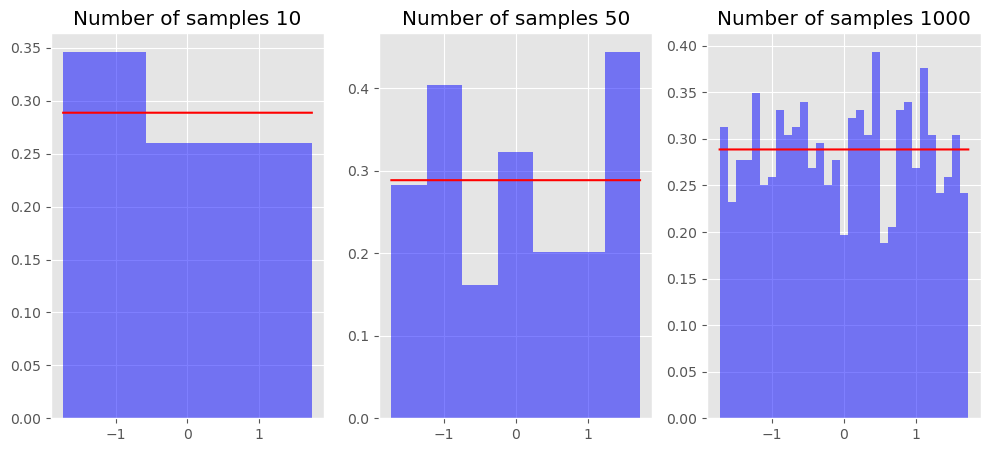

In [3]:
print_hist_dencity(stats.uniform(-np.sqrt(3), 2*np.sqrt(3)), (-np.sqrt(3), np.sqrt(3)), './uniform')

In [13]:
print(statistics(stats.poisson(10)).to_latex())

\begin{tabular}{lrlllrrr}
\toprule
 & Sample size & Mean & Median & $z_Q$ & Mean variance & Median variance & $z_Q$ variance \\
\midrule
0 & 10 & 10.0 ± 0.3 & 9.9 ± 0.4 & 10.0 ± 0.3 & 1.007028 & 1.472094 & 1.164962 \\
1 & 100 & 10.02 ± 0.03 & 9.87 ± 0.05 & 9.94 ± 0.04 & 0.098859 & 0.205124 & 0.149466 \\
2 & 1000 & 10.000 ± 0.003 & 9.998 ± 0.001 & 9.995 ± 0.002 & 0.009469 & 0.001996 & 0.003489 \\
\bottomrule
\end{tabular}



C:\Users\andre\AppData\Local\Temp\ipykernel_8548\2572413842.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ans['Mean'][i] = format_value_with_uncertainty(ans['Mean'][i], ans['Mean variance'][i], ans['Sample size'][i])
C:\Users\andre\Ap

In [15]:
print(statistics(stats.norm(0, 1)).to_latex())

\begin{tabular}{lrlll}
\toprule
 & Sample size & Mean & Median & $z_Q$ \\
\midrule
0 & 10 & -0.0 ± 0.1 & -0.0 ± 0.1 & 0.0 ± 0.1 \\
1 & 100 & 0.00 ± 0.01 & 0.00 ± 0.01 & 0.00 ± 0.01 \\
2 & 1000 & 0.001 ± 0.001 & 0.001 ± 0.001 & 0.002 ± 0.001 \\
\bottomrule
\end{tabular}



C:\Users\andre\AppData\Local\Temp\ipykernel_8548\3278180559.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ans['Mean'][i] = format_value_with_uncertainty(ans['Mean'][i], ans['Mean variance'][i], ans['Sample size'][i])
C:\Users\andre\Ap

In [16]:
print(statistics(stats.cauchy(0, 1)).to_latex())

\begin{tabular}{lrlll}
\toprule
 & Sample size & Mean & Median & $z_Q$ \\
\midrule
0 & 10 & 0 ± 10 & -0.0 ± 0.2 & -0.0 ± 0.3 \\
1 & 100 & -1 ± 3 & 0.01 ± 0.02 & 0.01 ± 0.02 \\
2 & 1000 & 0.8 ± 0.8 & -0.000 ± 0.002 & -0.001 ± 0.002 \\
\bottomrule
\end{tabular}



C:\Users\andre\AppData\Local\Temp\ipykernel_8548\3278180559.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ans['Mean'][i] = format_value_with_uncertainty(ans['Mean'][i], ans['Mean variance'][i], ans['Sample size'][i])
C:\Users\andre\Ap

In [17]:
print(statistics(stats.uniform(-np.sqrt(3), 2*np.sqrt(3))).to_latex())

\begin{tabular}{lrlll}
\toprule
 & Sample size & Mean & Median & $z_Q$ \\
\midrule
0 & 10 & 0.0 ± 0.1 & -0.0 ± 0.2 & -0.0 ± 0.1 \\
1 & 100 & -0.00 ± 0.01 & -0.00 ± 0.02 & -0.00 ± 0.01 \\
2 & 1000 & -0.000 ± 0.001 & 0.000 ± 0.002 & -0.001 ± 0.001 \\
\bottomrule
\end{tabular}



C:\Users\andre\AppData\Local\Temp\ipykernel_8548\3278180559.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ans['Mean'][i] = format_value_with_uncertainty(ans['Mean'][i], ans['Mean variance'][i], ans['Sample size'][i])
C:\Users\andre\Ap

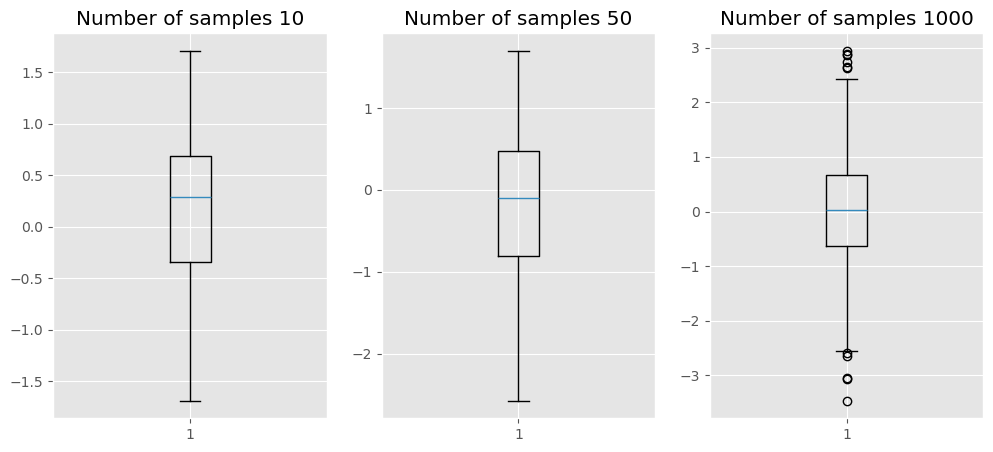

{10: 0, 50: 0, 1000: 11}

In [9]:
print_boxplot(stats.norm(0, 1), './images/norm_box')

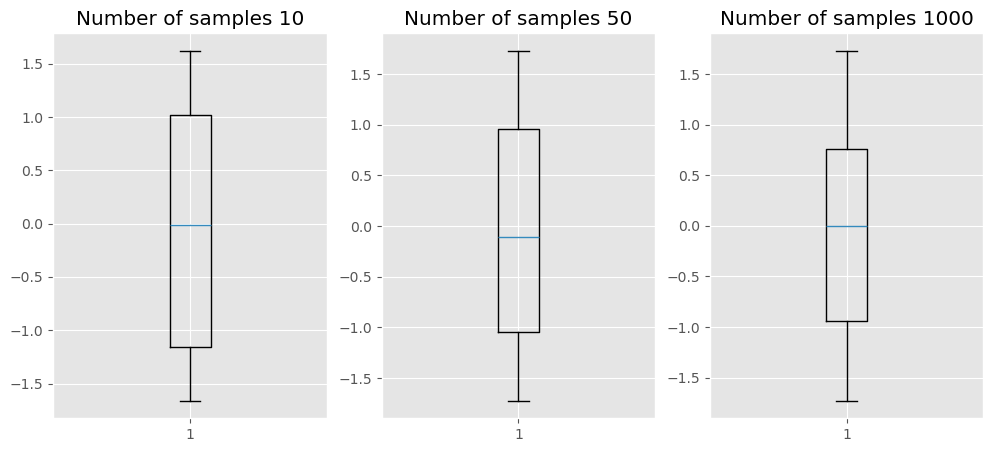

{10: 0, 50: 0, 1000: 0}

In [12]:
print_boxplot(stats.uniform(-np.sqrt(3), 2*np.sqrt(3)), './images/uni_box')

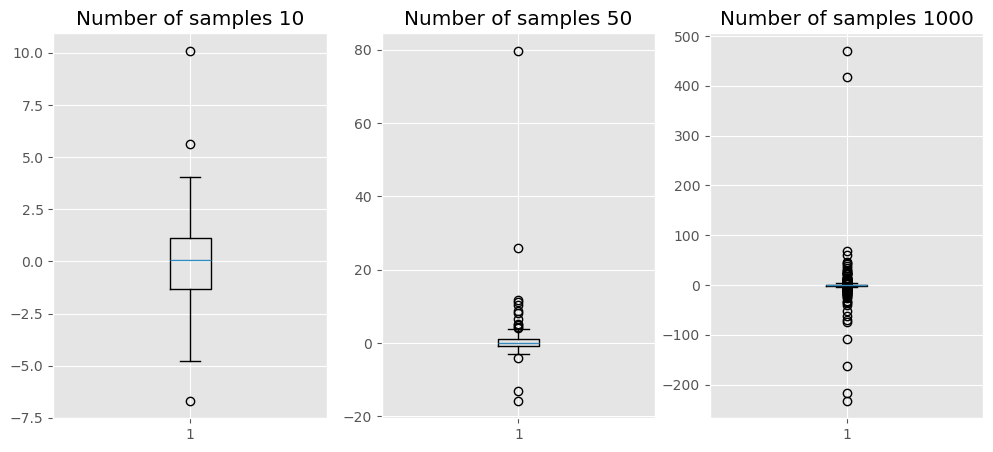

{10: 3, 50: 15, 1000: 159}

In [14]:
print_boxplot(stats.cauchy(0, 1), './images/cauchy_box')

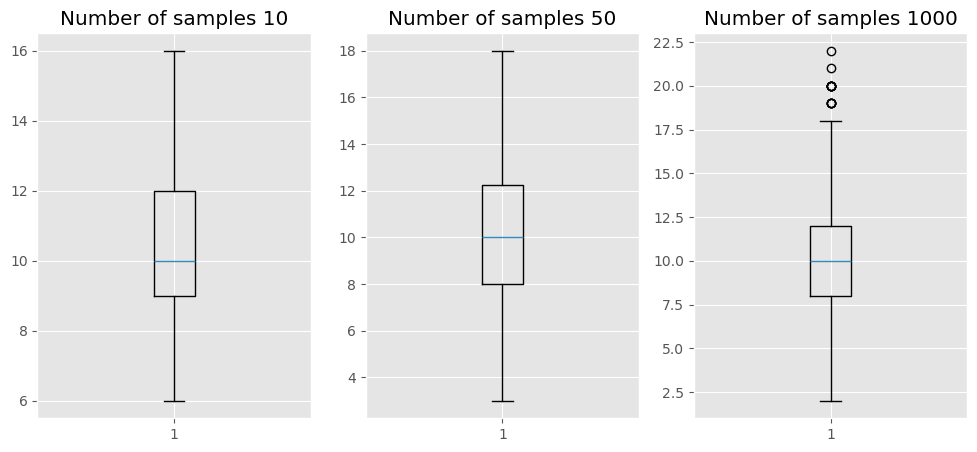

{10: 0, 50: 0, 1000: 14}

In [16]:
print_boxplot(stats.poisson(10), './images/poisson_box')